In [1]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime

import selenium
from selenium import webdriver
from time import sleep

import quandl

import seaborn as sns

import sys

from scipy.stats import norm

In [2]:
def port_eval(port, freq = 'D'):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
 
    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0])),
                                 float(ES)]},
                   index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR', 'ES'])
    

    
    return metrics 

In [3]:
def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [4]:
def backtest_strategy(data, W, tol, rebalance_freq, data_names, leverage = 1):
    initial = 1
    asset = [i * initial for i in W]
    port = []
    port_W = [] 

    if sum(W) == 1:

        for i in range(len(data)):
            #port.append(initial)
            port_W.append([i / initial for i in asset])
            
            daily_ret = ((data.iloc[i]-1) * leverage) +1
            asset = asset * daily_ret #data.iloc[i]
            initial = sum(asset)
            port.append(initial)
            #Rebalancing by days
            if i%rebalance_freq == 0:
                for i in range(len(W)):
                    asset[i] = initial * W[i]
            
            #Rebalancing by deviation
            for i in range(len(asset)):
                if abs(asset[i]/initial - W[i])> tol:  
                      asset = [i * initial for i in W]
    
        port = pd.DataFrame(port)
        port.index = data.index
    
        result = pd.concat([port, data.cumprod()], axis =1)
        result.columns = ["Portfolio"] + data_names
        
        return (result, port_W)
        
    else:
        print("Weight not Equal to 1!")

In [5]:
def strategy_evaluation(result, data_names, freq = 'D'):
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(metrics.columns), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(metrics.columns), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino' ],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility', 'ES'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.2%}", 'Max DD': "{:.2%}", 'ES': "{:.2%}", 'Volatility': "{:.2%}"})
      .set_table_styles(styles))
    
    return metrics

In [6]:
def correlation_map(result):
    ret = calc_port_ret(result)
    ret = np.log(ret)
    corr = ret.corr()
    th_props = [
      ('font-size', '11px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'Black'),
      ('background-color', '#f7f7f9')
      ]

    
        # Set CSS properties for td elements in dataframe
    td_props = [
          ('font-size', '11px'), ('text-align', 'center')
          ]
    
        # Set table styles
    styles = [
          dict(selector="th", props=th_props),
          dict(selector="td", props=td_props)
          ]
    
    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)
    
    
    corr = (corr.style
          .background_gradient(axis = 0 ,cmap=cm_neg_good)
          .set_table_styles(styles))
    
    return corr

# Backtesting Portfolio

TODO:
- collect data, dividned adjusted
- leverage
- start and end date

In [7]:
SP500_daily_tmp = yf.download("^SP500TR")
SHY_daily_tmp = yf.download("SHY")
TLT_daily_tmp =  yf.download("TLT")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
SP500_daily= pd.DataFrame(SP500_daily_tmp['Close'])
SHY_daily = pd.DataFrame(SHY_daily_tmp['Close'])
TLT_daily = pd.DataFrame(TLT_daily_tmp['Close'])

SP500_daily.columns = ['SP500']
SHY_daily.columns = ['SHY']
TLT_daily.columns = ['TLT']

In [9]:
# TYX, 30 yr Treasury

TYX_tmp = yf.download('^TYX')
TYX = pd.DataFrame(TYX_tmp['Close'])
ttm = 30

TYX.insert(1, "Price Change", 0.0, True)
TYX_yield = TYX['Close']
row = 0
price = 1

TYX_price = pd.DataFrame(index=TYX_yield.index)
TYX_price.insert(0, "Price Change", 0.0, True)
for i in TYX_yield:
    prev_price = price
    price = 1/(1+i/100)**ttm
    price_change = (price-prev_price)/prev_price
    TYX_price['Price Change'][row] = round(price_change, 2)
    row += 1

TYX_price['Price Change'][0] = 0
TYX_price = TYX_price[:-1]

TYX_price.insert(1, "TYX", 100.0, True)
price = 100
row = 0

for i in TYX_price['Price Change']:
    price = price*(1+i)
    TYX_price['TYX'][row] = price
    row += 1
    
TYX = pd.DataFrame(TYX_price['TYX'])

[*********************100%***********************]  1 of 1 completed


In [11]:
# TNX 10 year gov bond

TNX_tmp = yf.download('^TNX')
TNX = pd.DataFrame(TNX_tmp['Close'])
ttm = 10

TNX.insert(1, "Price Change", 0.0, True)
TNX_yield = TNX['Close']
row = 0
price = 1

TNX_price = pd.DataFrame(index=TNX_yield.index)
TNX_price.insert(0, "Price Change", 0.0, True)
for i in TNX_yield:
    prev_price = price
    price = 1/(1+i/100)**ttm
    price_change = (price-prev_price)/prev_price
    TNX_price['Price Change'][row] = round(price_change, 2)
    row += 1

TNX_price['Price Change'][0] = 0
TNX_price = TNX_price[:-1]

TNX_price.insert(1, "TNX", 100.0, True)
price = 100
row = 0

for i in TNX_price['Price Change']:
    price = price*(1+i)
    TNX_price['TNX'][row] = price
    row += 1
    
TNX = pd.DataFrame(TNX_price['TNX'])

[*********************100%***********************]  1 of 1 completed


In [ ]:
# FVX 5 year gov bond

FVX_tmp = yf.download('^FVX')
FVX = pd.DataFrame(FVX_tmp['Close'])
ttm = 10

FVX.insert(1, "Price Change", 0.0, True)
FVX_yield = FVX['Close']
row = 0
price = 1

FVX_price = pd.DataFrame(index=TNX_yield.index)
TNX_price.insert(0, "Price Change", 0.0, True)
for i in TNX_yield:
    prev_price = price
    price = 1/(1+i/100)**ttm
    price_change = (price-prev_price)/prev_price
    TNX_price['Price Change'][row] = round(price_change, 2)
    row += 1

TNX_price['Price Change'][0] = 0
TNX_price = TNX_price[:-1]

TNX_price.insert(1, "TNX", 100.0, True)
price = 100
row = 0

for i in TNX_price['Price Change']:
    price = price*(1+i)
    TNX_price['TNX'][row] = price
    row += 1
    
TNX = pd.DataFrame(TNX_price['TNX'])

In [12]:
#Gold Import
Gold_tmp = quandl.get("LBMA/GOLD", authtoken="6rNSyTM5R4g7_B7XSyQW")

In [13]:
Gold = pd.DataFrame(Gold_tmp["USD (AM)"])
Gold_monthly = Gold.resample('M').last()
Gold.columns = ['Gold']
Gold_monthly.columns = ['Gold']

In [14]:
#Long Vol Import
long_vol_imp = pd.read_excel (r'https://www.eurekahedge.com/Indices/ExportIndexReturnsToExcel?IndexType=Eurekahedge&IndexId=640')

long_vol = long_vol_imp[3:]
long_vol.index= pd.to_datetime(long_vol_imp[3:]['Unnamed: 0'])
long_vol = pd.DataFrame(long_vol['Unnamed: 2'])
long_vol.columns = ["Long Vol"]

In [15]:
#Monthly SP500
SP500_monthly = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken="6rNSyTM5R4g7_B7XSyQW")
SP500_monthly.columns = ['SP500']

In [16]:
####DAILY DATA#########

data = pd.concat([SP500_daily,Gold,TNX], axis = 1) #asset_2, asset_4
data = data.ffill()
data = data.dropna()
data = data/data.shift(1)
data = data.fillna(1)

In [17]:
######## Monthly Data

data_tmp = pd.concat([SP500_monthly, long_vol], axis = 1)
data_tmp = data_tmp.ffill()
data_tmp = data_tmp.dropna()
monthly_data = data_tmp/data_tmp.shift()
monthly_data = monthly_data.fillna(1)
monthly_data = monthly_data.ffill()
monthly_data = monthly_data.dropna()

In [18]:
rebalance_freq = 252/4
tol = 0.1
W = [1/3, 1/3,1/3]

data_names = data.columns.tolist()


result, weights = backtest_strategy(data, W, tol, rebalance_freq, data_names, leverage = 1)

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR,ES
Portfolio,5.74%,8.10%,0.710000,0.960000,-20.00%,0.290000,1.00%
SP500,10.33%,17.90%,0.580000,0.690000,-55.00%,0.190000,2.30%
Gold,4.05%,15.60%,0.260000,0.340000,-48.00%,0.080000,2.00%
TNX,0.82%,9.40%,0.090000,0.160000,-28.00%,0.030000,1.20%


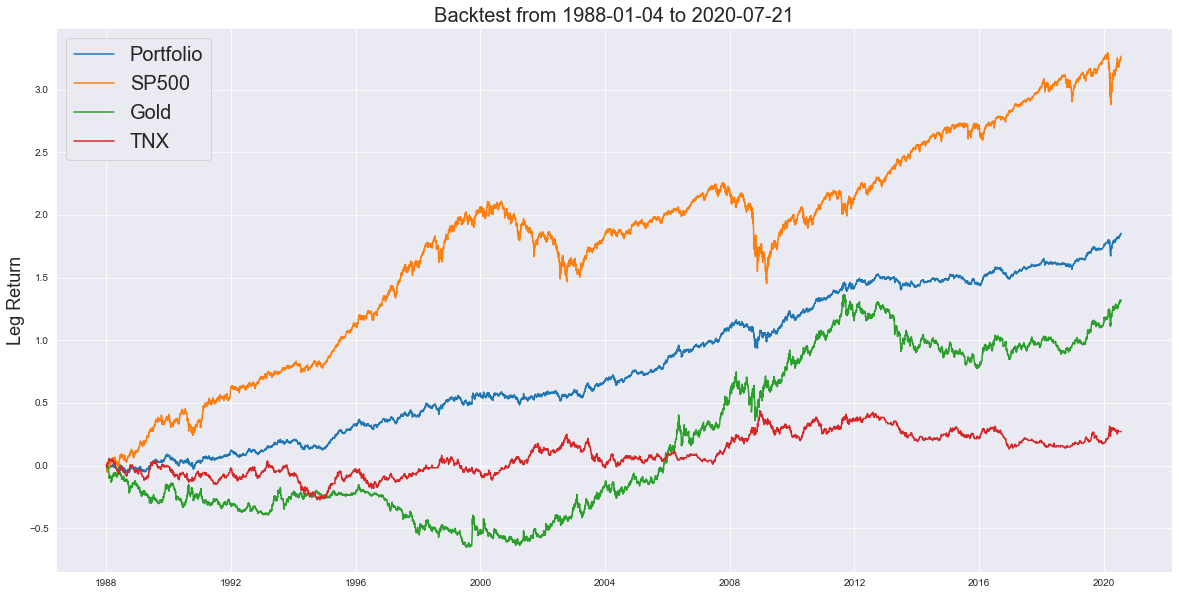

In [19]:
sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in result.columns:
    plt.plot(np.log(result[i]), label = i);

start = datetime.date(result.index.min());
end = datetime.date(result.index.max());
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
plt.ylabel('Leg Return', fontsize=18)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

strategy_evaluation(result, data_names, freq = 'D')


In [ ]:
correlation_map(result)